## Importing Python Libraries

In [1]:
import numpy as np
import pandas as pd
import neattext.functions as nfx
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import joblib
import gensim
from gensim.models import FastText

## Loading the Datasets and Merging them to Single Dataset

In [2]:
df1 = pd.read_csv('../Datasets/goemotions_1.csv')
df2 = pd.read_csv('../Datasets/goemotions_2.csv')
df3 = pd.read_csv('../Datasets/goemotions_3.csv')
df = pd.concat([df1, df2, df3], axis=0)

## Emotion Columns and Overall Labels

In [3]:
positive = ["admiration","amusement","approval","caring","curiosity","desire","excitement","gratitude","joy","love","optimism","pride","relief"]
negative = ["anger","annoyance","confusion","disappointment","disapproval","disgust","embarrassment","fear","grief","nervousness","remorse","sadness"]
neutral = ["realization","surprise","neutral"]

def Emotion_Labels(row):
    if row[positive].sum() > 0:
        return "Positive"
    elif row[negative].sum() > 0:
        return "Negative"
    elif row[neutral].sum() > 0:
        return "Neutral"
    else:
        return pd.NA

df['Emotions'] = df.apply(Emotion_Labels, axis=1)
df.dropna(inplace=True)

## Finding out the Value Counts of Emotions in the Dataset

In [4]:
df['Emotions'].value_counts()

Emotions
Positive    90895
Neutral     63706
Negative    53213
Name: count, dtype: int64

## Balancing the Class

In [5]:
target = 53000
classes = ['Positive', 'Neutral', 'Negative']
balanced_frames = []
for cls in classes:
    cls_df = df[df['Emotions'] == cls]
    if len(cls_df) >= target:
        cls_df_bal = cls_df.sample(n=target, random_state=42)
    else:
        cls_df_bal = cls_df.sample(n=target, replace=True, random_state=42)
    balanced_frames.append(cls_df_bal)

In [6]:
bdf = pd.concat(balanced_frames).sample(frac=1, random_state=42).reset_index(drop=True)
bdf['Emotions'].value_counts()

Emotions
Neutral     53000
Negative    53000
Positive    53000
Name: count, dtype: int64

## Preparing the Dataset for Training and Testing

In [7]:
dff = pd.DataFrame()
dff['Text'] = (bdf['text'].astype(str) +
    ' | Author: ' + bdf['author'].astype(str) +
    ' | Subreddit: ' + bdf['subreddit'].astype(str)
)
dff['Emotions'] = bdf['Emotions']
dff.head()

,Text,Emotions
0,Some couples have a “cheat list” of celebritie...,Neutral
1,"I am 63, D cups, no sag. I must be a unicorn! ...",Neutral
2,Unfortunately no one usually fights for their ...,Negative
3,Is everybody forgetting that bills need to be ...,Negative
4,"Nice, congrats! | Author: sarcasmbunny | Subre...",Positive


In [8]:
del df1,df2,df3,df,bdf

## Cleaning the Text

In [9]:
def clean(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'\br/\w+', '', text)
    text = text.replace('\n', ' ')
    text = re.sub(r'[{}\[\]()\|:\"\']', ' ', text)
    text = re.sub(r'[“”‘’]', ' ', text)            
    text = re.sub(r'\|{2,}', ' ', text)              
    text = nfx.remove_emails(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_userhandles(text)
    text = nfx.remove_phone_numbers(text)
    text = nfx.remove_emojis(text)
    text = nfx.remove_puncts(text)
    text = nfx.remove_multiple_spaces(text)
    text = re.sub(r'[^a-z0-9 ]', ' ', text)           
    text = re.sub(r'\s{2,}', ' ', text)              
    return text.strip()

dff['Text'] = dff['Text'].apply(clean)
dff.head()

,Text,Emotions
0,couples cheat list celebrities entitled with b...,Neutral
1,63 cups sag unicorn author getoffmylawn subred...,Neutral
2,unfortunately usually fights rights martyr aut...,Negative
3,everybody forgetting bills need signed preside...,Negative
4,nice congrats author sarcasmbunny subreddit as...,Positive


In [10]:
dff['Emotions'].value_counts()

Emotions
Neutral     53000
Negative    53000
Positive    53000
Name: count, dtype: int64

## Training and Testing Split

In [11]:
x = dff['Text']
y = dff['Emotions']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

## FastText Embedding Preparation

#### Training a FastText model on Training Data or Load a Pretrained One

In [12]:
tokenized_texts = [sentence.split() for sentence in x_train]
ft_model = FastText(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, epochs=10, workers=4)

#### Function to get average FastText Embedding for each sentence

In [13]:
def get_sentence_vector(model, sentence, size=100):
    words = sentence.split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(size)

X_train_ft = np.vstack([get_sentence_vector(ft_model, sent, size=ft_model.vector_size) for sent in x_train])
X_test_ft = np.vstack([get_sentence_vector(ft_model, sent, size=ft_model.vector_size) for sent in x_test])

## Encoding Labels

In [14]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Model Construction and Training

#### Logistic Regression

In [15]:
log_clf = LogisticRegression(C=1, penalty='l2', solver='lbfgs', class_weight='balanced', max_iter=300, random_state=42)
log_clf.fit(X_train_ft, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,300
,multi_class,'deprecated'


#### XGBoost Classifier

In [16]:
xgb_clf = XGBClassifier(n_estimators=200, max_depth=10, learning_rate=0.1,objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, random_state=42)
xgb_clf.fit(X_train_ft, y_train_enc)

,objective,'multi:softmax'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


#### LightBGM Classifier

In [17]:
lgbm_clf = LGBMClassifier(n_estimators=200, max_depth=10, learning_rate=0.1, class_weight='balanced', random_state=42)
lgbm_clf.fit(X_train_ft, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25500
[LightGBM] [Info] Number of data points in the train set: 127200, number of used features: 100
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,10
,learning_rate,0.1
,n_estimators,200
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


## Predictions

In [18]:
log_pred = log_clf.predict(X_test_ft)
xgb_pred_enc = xgb_clf.predict(X_test_ft)
xgb_pred = le.inverse_transform(xgb_pred_enc)
lgbm_pred = lgbm_clf.predict(X_test_ft)

## Evaluation

In [19]:
print("Logistic Regression:")
print(f'Accuracy Score: {accuracy_score(y_test, log_pred)}')
print(f'Precision Score (macro): {precision_score(y_test, log_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, log_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, log_pred, average="macro")}')

print()

print("XGBoost:")
print(f'Accuracy Score: {accuracy_score(y_test, xgb_pred)}')
print(f'Precision Score (macro): {precision_score(y_test, xgb_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, xgb_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, xgb_pred, average="macro")}')

print()

print("LightGBM:")
print(f'Accuracy Score: {accuracy_score(y_test, lgbm_pred)}')
print(f'Precision Score (macro): {precision_score(y_test, lgbm_pred, average="macro")}')
print(f'Recall Score (macro): {recall_score(y_test, lgbm_pred, average="macro")}')
print(f'F1 Score (macro): {f1_score(y_test, lgbm_pred, average="macro")}')

Logistic Regression:
Accuracy Score: 0.5311635220125787
Precision Score (macro): 0.5374047247776993
Recall Score (macro): 0.5311635220125787
F1 Score (macro): 0.5326942446626634

XGBoost:
Accuracy Score: 0.5990251572327044
Precision Score (macro): 0.600383097848757
Recall Score (macro): 0.5990251572327043
F1 Score (macro): 0.5994749598258694

LightGBM:
Accuracy Score: 0.5570125786163522
Precision Score (macro): 0.5647525849693196
Recall Score (macro): 0.5570125786163521
F1 Score (macro): 0.5587224475176419


## Confusion Matrix Visualization

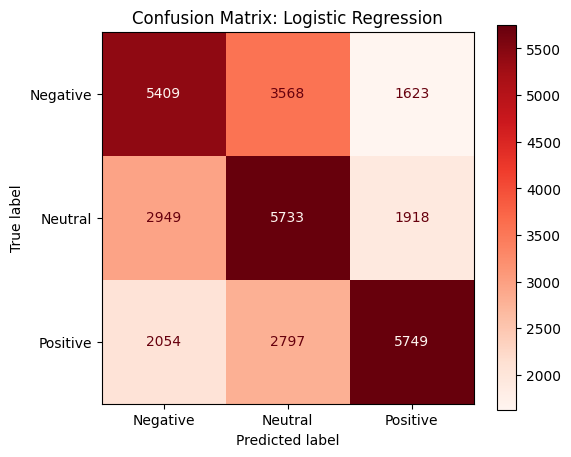

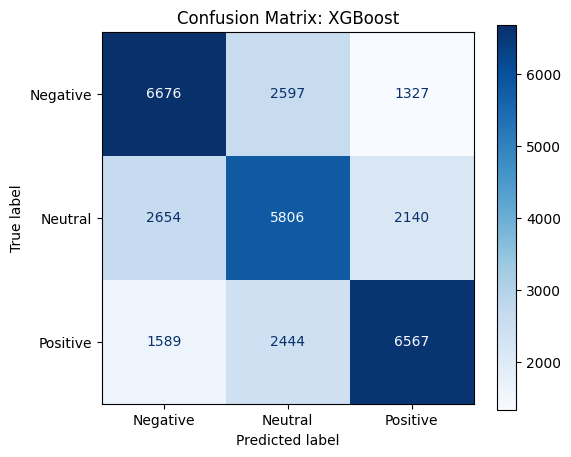

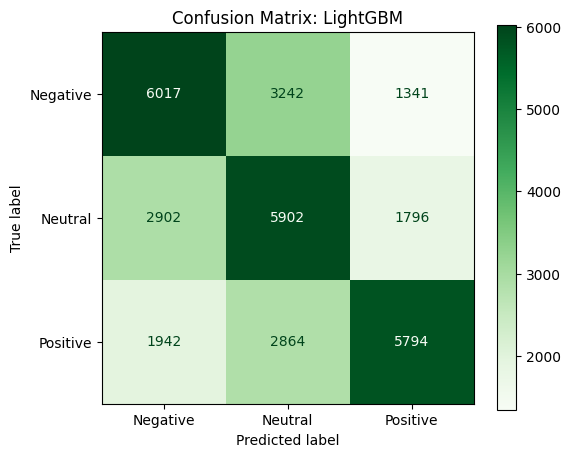

In [20]:
models = {
    'Logistic Regression': log_pred,
    'XGBoost': xgb_pred,
    'LightGBM': lgbm_pred
}
cmaps = {
    'Logistic Regression': 'Reds',
    'XGBoost': 'Blues',
    'LightGBM': 'Greens'
}
labels = le.classes_
for name, preds in models.items():
    cm = confusion_matrix(y_test, preds, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,5))
    disp.plot(cmap=cmaps[name], ax=ax, values_format='d')
    plt.title(f'Confusion Matrix: {name}')
    plt.show()

## Compare Metrics

In [21]:
metric_dict = {}
for name, preds in models.items():
    metric_dict[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, average='macro'),
        'Recall': recall_score(y_test, preds, average='macro'),
        'F1': f1_score(y_test, preds, average='macro')
    }
metrics_df = pd.DataFrame(metric_dict).T
metrics_df

,Accuracy,Precision,Recall,F1
Logistic Regression,0.531164,0.537405,0.531164,0.532694
XGBoost,0.599025,0.600383,0.599025,0.599475
LightGBM,0.557013,0.564753,0.557013,0.558722
